# Elementary research

This notebook examines several basic assembly operations.

In [1]:
%load_ext autoreload
%autoreload 2

import lascar

import datasets
from datasets import randints
import analyze
import capture
import plot

import warnings
warnings.filterwarnings('ignore')

In [2]:
def asmcapture(target, number_of_traces, inputfunction, asmcode, number_of_samples=100):
    asmcode = "\n".join([f'"{line} \\n"' for line in asmcode.splitlines()])

    additional_args = {}
    if target.startswith("cw"):
        additional_args["number_of_samples"] = number_of_samples

    return capture.capture_generic(
        name=target,
        number_of_traces=number_of_traces,
        inputfunction=inputfunction,
        code=f'asm(\n{asmcode}\n:: "r"(input));',
        **additional_args,
    )

## Behavior of different bytes in one operation

In reality different different bytes of a 32-bit word have different leakage behavior.
This is also reflected by ELMO and can be made visible!

In [3]:
data = asmcapture(
    target="elmo",
    number_of_traces=10_000,
    inputfunction=lambda: randints(4),
    asmcode="""
        ldr r0, [%0]
        """
)

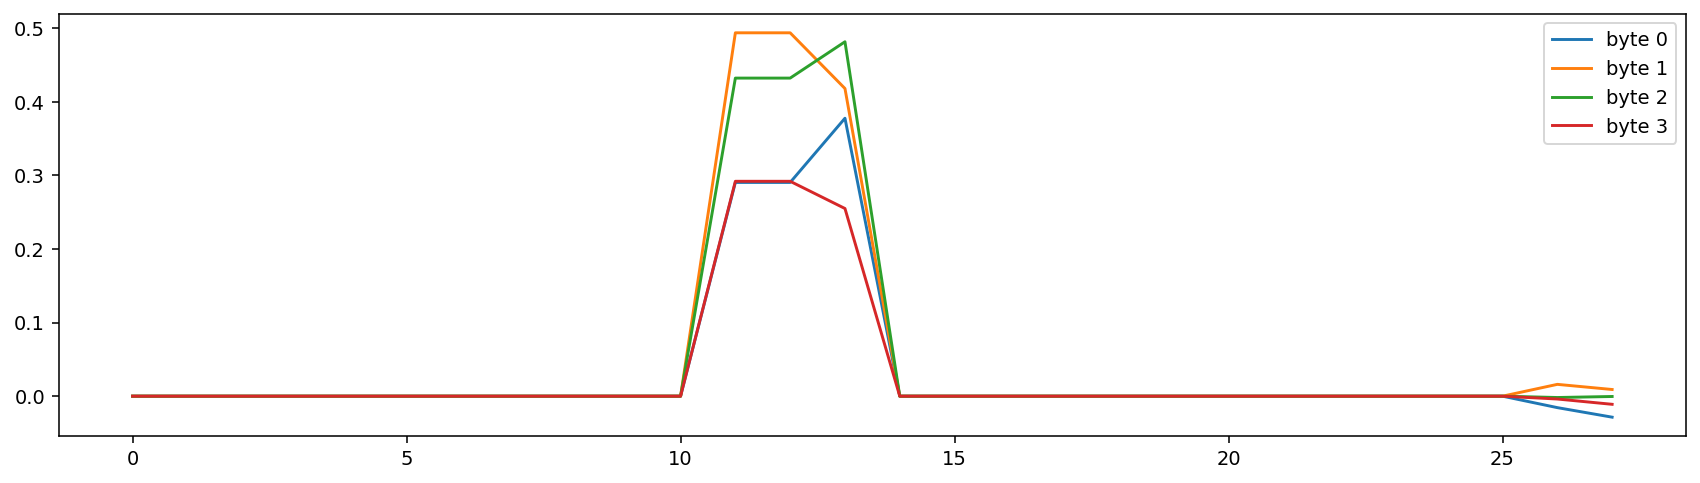

In [4]:
cpas = analyze.cpa(
    dataset=data,
    selection_functions={
        'byte 0': lambda value, _: lascar.hamming(value["input"][0]),
        'byte 1': lambda value, _: lascar.hamming(value["input"][1]),
        'byte 2': lambda value, _: lascar.hamming(value["input"][2]),
        'byte 3': lambda value, _: lascar.hamming(value["input"][3]),
    }
)

fig = plot.plot_lines(cpas)
fig.show()

## Collision on Memory Bus

In [5]:
data = asmcapture(
    target="elmo",
    number_of_traces=10_000,
    inputfunction=lambda: randints(8),
    asmcode="""
        ldr r0, [%0]
        nop\nnop\nnop\nnop\n
        nop\nnop\nnop\nnop
        ldr r1, [%0, #4]
        """
)

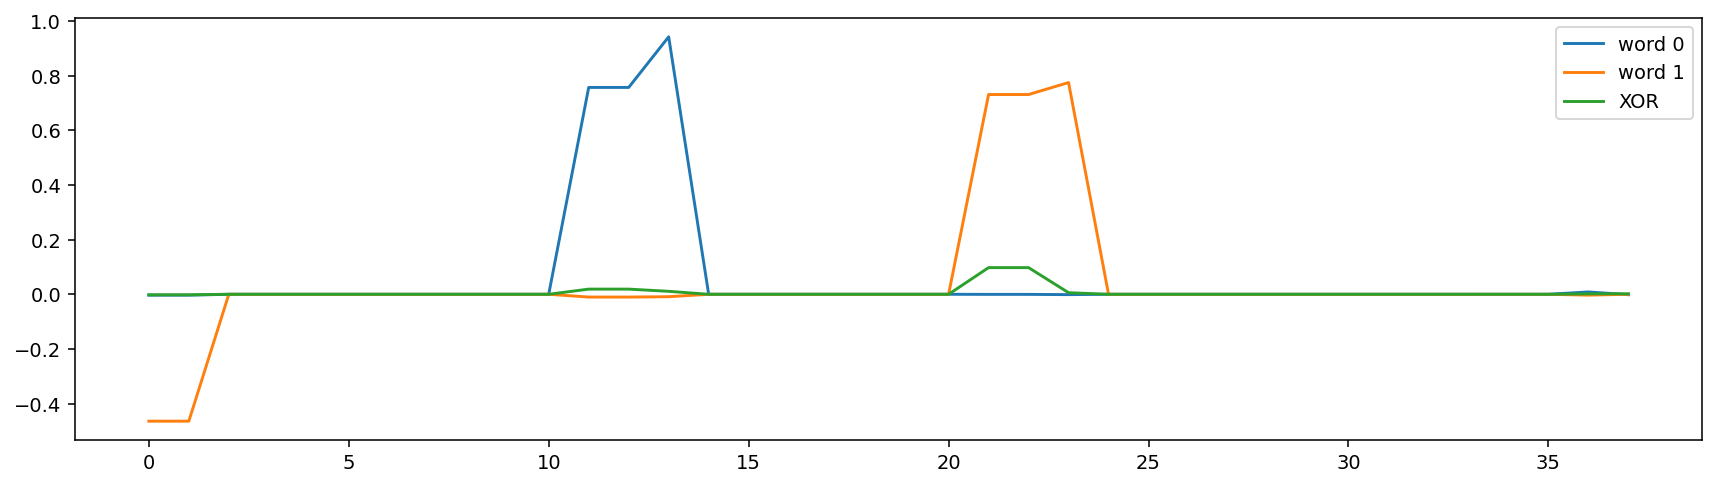

In [6]:
cpas = analyze.cpa(
    dataset=data,
    selection_functions={
        "word 0": lambda value, _: sum([lascar.hamming(i) for i in value["input"][0:4]]),
        "word 1": lambda value, _: sum([lascar.hamming(i) for i in value["input"][4:8]]),
        "XOR": lambda value, _: sum(
            [lascar.hamming(i1 ^ i2) for i1, i2 in zip(value["input"][0:4], value["input"][4:8])]
        ),
    },
)
fig = plot.plot_lines(cpas)
fig.show()

## Leakage of neighboring bytes

In [7]:
data = asmcapture(
    target="elmo",
    number_of_traces=10_000,
    inputfunction=lambda: randints(4),
    asmcode="""
        ldrb r0, [%0]
        """
)

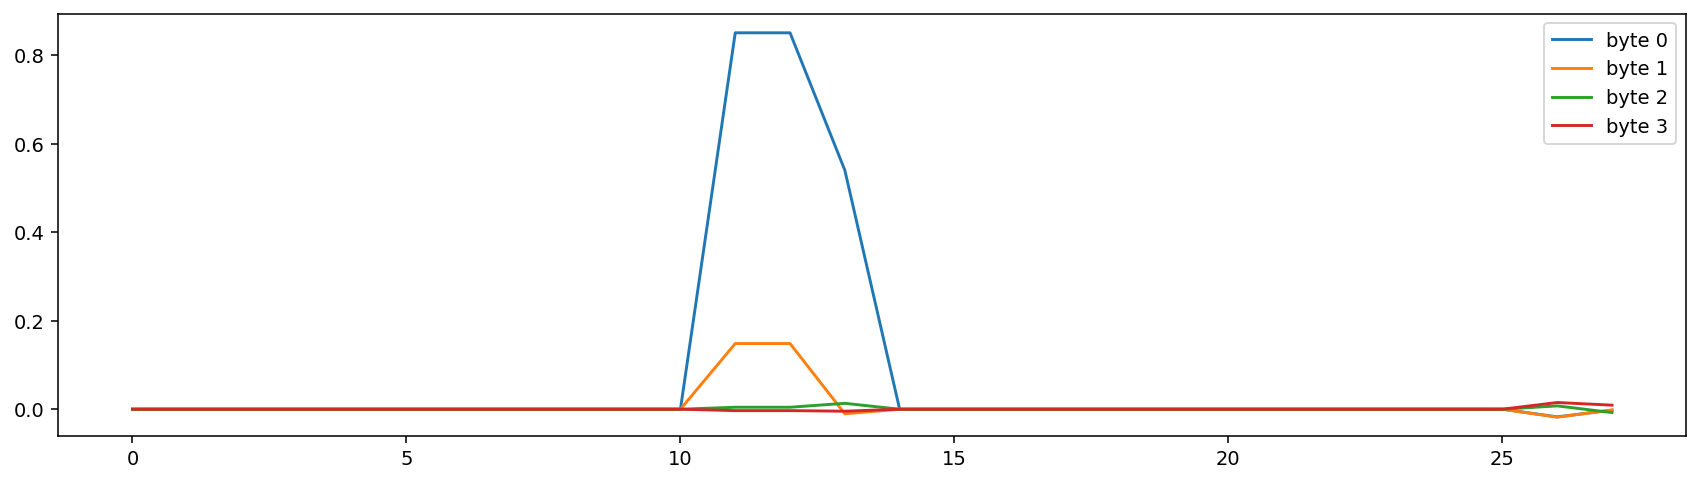

In [8]:
cpas = analyze.cpa(
    dataset=data,
    selection_functions={
        'byte 0': lambda value, _: lascar.hamming(value["input"][0]),
        'byte 1': lambda value, _: lascar.hamming(value["input"][1]),
        'byte 2': lambda value, _: lascar.hamming(value["input"][2]),
        'byte 3': lambda value, _: lascar.hamming(value["input"][3]),
    }
)

fig = plot.plot_lines(cpas)
fig.show()

# Second Order

In [9]:
def cpa_full_secondorder(dataset, selection_function, guess_range, rois):
    class CpaOutput(lascar.OutputMethod):
        def _update(self, engine, results):
            self.result = results[0]

    trace = lascar.TraceBatchContainer(dataset["trace"], dataset)
    trace.leakage_processing = lascar.CenteredProductProcessing(
        container=trace,
        rois=rois,
        batch_size=100_000
    )

    engine = lascar.CpaEngine(
        name=f"cpa",
        selection_function=selection_function,
        guess_range=guess_range,
    )
    output_method = CpaOutput(engine)
    session = lascar.Session(
        trace,
        engine=engine,
        output_method=output_method,
        progressbar=False,
    )
    session.run(batch_size=100_000)
    return output_method.result

In [10]:
data = asmcapture(
    target="elmo",
    number_of_traces=10_000,
    inputfunction=lambda: randints(3),
    asmcode="""
        ldrb r0, [%0]
        ldrb r0, [%0, #2]
        nop\nnop\nnop\nnop
        ldrb r1, [%0, #1]
        """
)

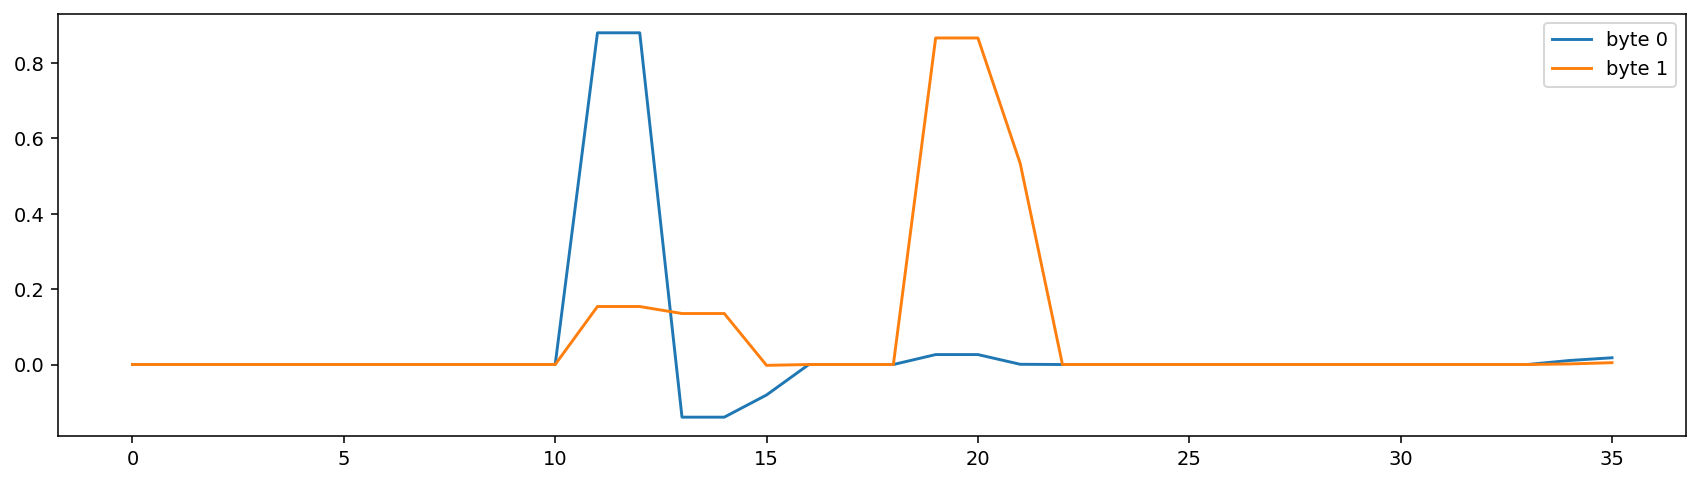

In [11]:
cpas = analyze.cpa(
    dataset=data,
    selection_functions={
        'byte 0': lambda value, _: lascar.hamming(value["input"][0]),
        'byte 1': lambda value, _: lascar.hamming(value["input"][1]),
    }
)

fig = plot.plot_lines(cpas)
fig.show()


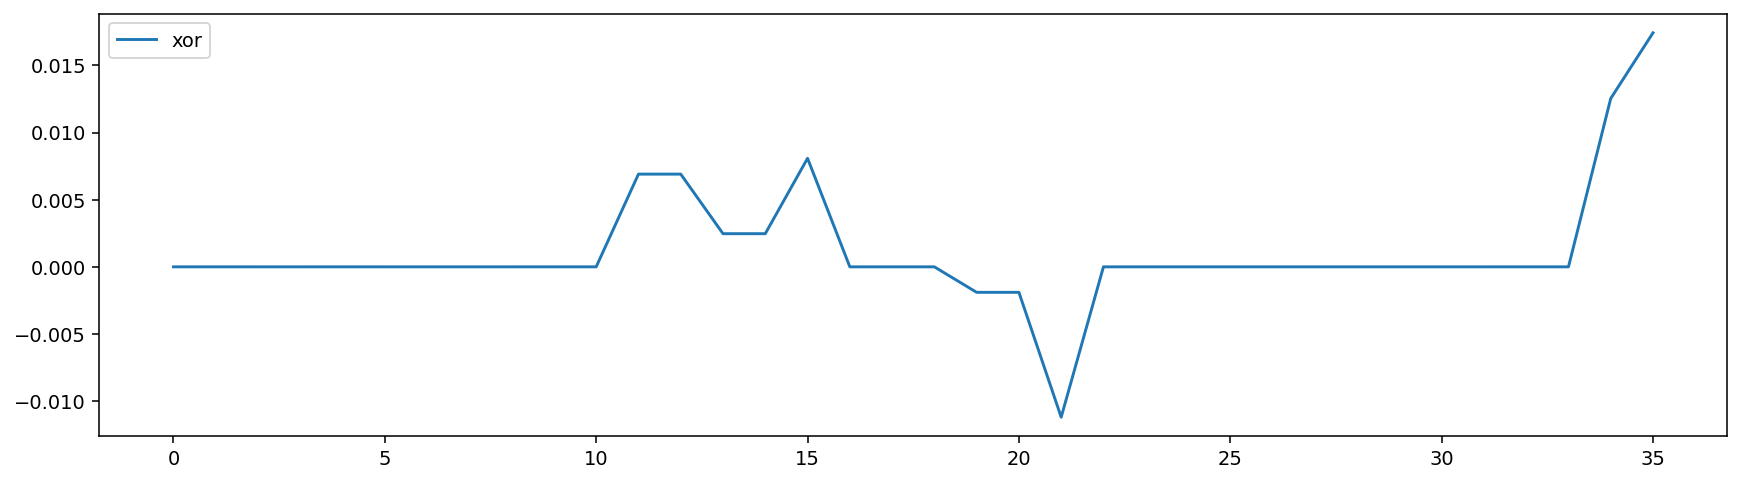

In [12]:
cpas = analyze.cpa(
    dataset=data,
    selection_functions={
        'xor': lambda value, _: lascar.hamming(value["input"][0] ^ value["input"][1]),
    }
)

fig = plot.plot_lines(cpas)
fig.show()

CenteredProduct: |100%||10000 trc/10000 | (2 engines, batch_size=100000, leakage_shape=(36,)) |Time:  0:00:00


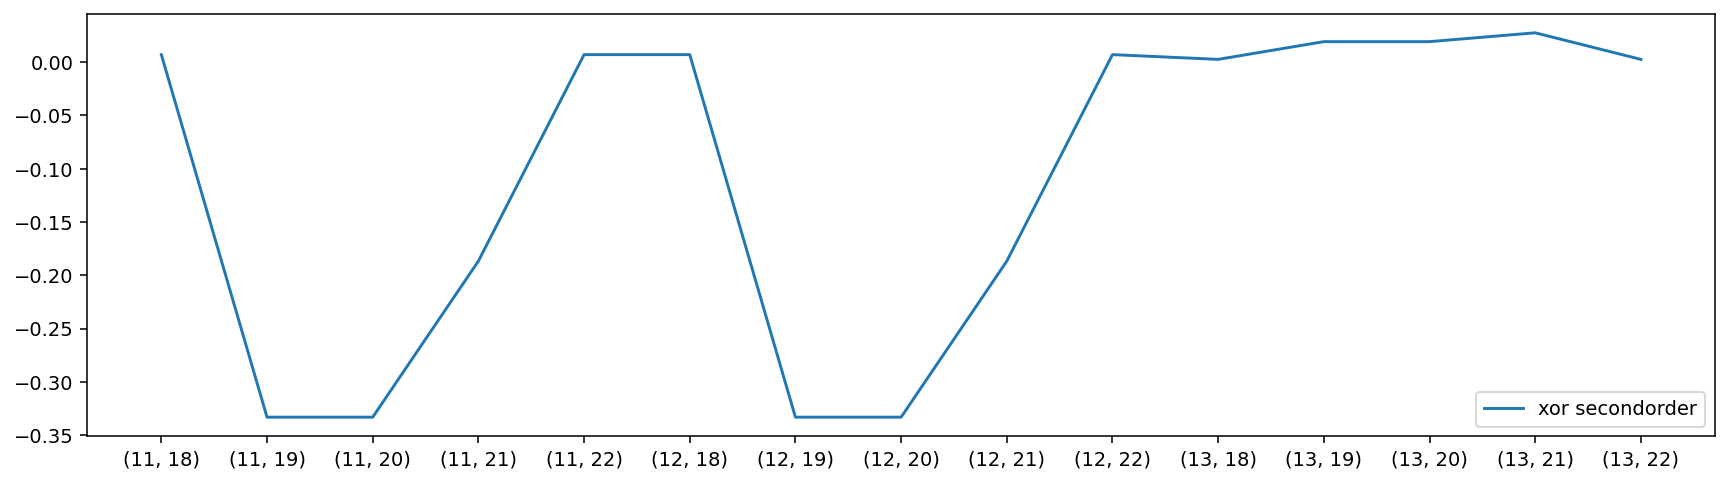

In [13]:
import itertools
rois = (range(11, 14), range(18, 23))
cpas = analyze.cpa(
    dataset=data,
    selection_functions={
        'xor secondorder': lambda value, _: lascar.hamming(value["input"][0] ^ value["input"][1]),
    },
    higherorder_rois=rois,
)

fig = plot.plot_lines([('xor secondorder', [(str(x), y) for x, y in zip(itertools.product(*rois), cpas[0][1])])])
fig.show()
